In [491]:
%load_ext autoreload
%autoreload 2
import gc
import sys

gc.collect()

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)

import pandas as pd

from ams.services.equities.EquityFundaDimension import EquityFundaDimension
%matplotlib inline
from pathlib import Path

from ams.config import constants
from ams.services import twitter_service
from ams.services import ticker_service

from statistics import mean
import numpy as np
from ams.services import file_services
from typing import List

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [492]:
twitter_folder = 'twitter'

tr_file_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, "tip_ranked", "main", "tip_rank_2020-12-14_22-48-27-354.17.parquet")

learning_prep_dir = Path(constants.DATA_PATH, twitter_folder, "great_reduction", "main")

file_paths = file_services.list_files(parent_path=learning_prep_dir, ends_with=".parquet", use_dir_recursion=True)

In [493]:
%%time

all_dfs = []
for f in file_paths:
    df = pd.read_parquet(f)
    all_dfs.append(df)

df_twitter_raw = pd.concat(all_dfs, axis=0)

max_date = df_twitter_raw["date"].max()
print(f"Max date: {max_date}")
print(f"Count: {df_twitter_raw.shape[0]}")

Max date: 2020-12-27
Count: 228582
Wall time: 1.71 s


Wall time: 530 ms


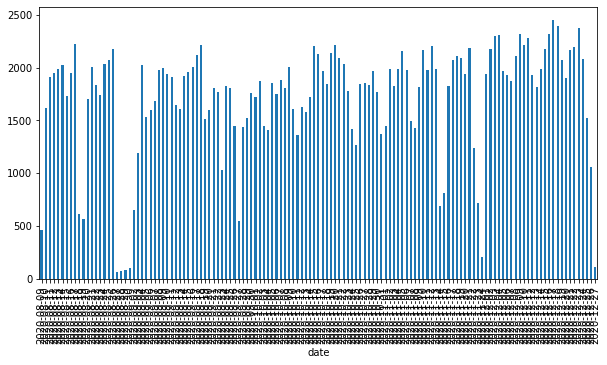

In [494]:
%%time 

twitter_ml_utils.show_distribution(df=df_twitter_raw)

In [495]:
%%time

df_booled = twitter_service.convert_to_bool(df=df_twitter_raw)

Wall time: 4.07 s


In [496]:
%%time

df_twitter = twitter_ml_utils.convert_twitter_to_numeric(df=df_booled)

Wall time: 103 ms


In [497]:
%%time

df_stock_data = twitter_service.get_stock_data_for_twitter_companies(df_tweets=df_twitter, num_days_in_future=5)

Wall time: 40.7 s


In [498]:
%%time

df_rec_quart_drop = twitter_service.get_all_quarterly_data_for_twitter()

columns_fundy = list(df_rec_quart_drop.columns)

Wall time: 6.72 s


In [499]:
%%time

df_result = twitter_ml_utils.merge_fundies_with_stock(df_stock_data=df_stock_data)

Wall time: 8.81 s


In [500]:
df_drop_init = df_result.dropna(subset=["date"]).drop(columns="lastupdated_eq_fun")

df_drop_future = df_drop_init[df_drop_init["date"] > df_drop_init["calendardate"]]

df_drop_future = df_drop_future.sort_values(by=["ticker", "date", "calendardate"], ascending=False)

df_stock_and_quarter = df_drop_future.drop_duplicates(subset=["ticker", "date"], keep="first")

In [501]:
df_nas_tickers_info = ticker_service.get_nasdaq_tickers()

C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniques = list(set(uniques))
C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [502]:
%time

col_ticker = "ticker_drop"

df_stock_quart_info = pd.merge(df_stock_and_quarter, df_nas_tickers_info, how='inner', left_on=["ticker"], right_on=[col_ticker])
df_sqi = df_stock_quart_info.drop(columns=[col_ticker])

Wall time: 0 ns


In [503]:
%%time

df_stock_renamed = df_sqi.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker","date"], right_on=["f22_ticker","date"])

print(f'Num merged: {df_merged.shape[0]}')

Num merged: 205241
Wall time: 2.62 s


In [504]:
df_days = twitter_ml_utils.add_days_since_quarter_results(df=df_merged)

In [505]:
%%time

df_days_of = twitter_ml_utils.add_calendar_days(df=df_days)

Wall time: 13.3 s


In [506]:
%%time

df_dd = twitter_ml_utils.add_nasdaq_roi(df=df_days_of)

Wall time: 3.02 s


In [507]:
%%time

df_thin_rabbit = twitter_service.add_buy_sell(df=df_dd)

Wall time: 231 ms


In [508]:
df_thin_rabbit["original_close_price"] = df_thin_rabbit["close"]
df_thin_rabbit["date"].max()
print(f'Num df_thin_rabbit: {df_thin_rabbit.shape[0]}')

Num df_thin_rabbit: 102649


In [509]:
# save_twitter_stock_join(df=df_thin_rabbit)

In [510]:
%%time
cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

df_no_z = twitter_service.fill_null_numeric(df=df_thin_rabbit, cols_fundy_numeric=cols_fundy_numeric)

Wall time: 435 ms


In [511]:
%%time
    
df_since_sma = twitter_ml_utils.add_sma_stuff(df=df_no_z)

Wall time: 1min 37s


In [512]:
%%time

df_since_sma["purchase_date"] = df_since_sma["date"]

Wall time: 1 ms


In [513]:
%%time

df_days_until = ticker_service.add_days_until_sale(df=df_since_sma)

Wall time: 3.89 s


In [514]:
%%time
df = twitter_service.refine_pool(df=df_days_until, min_volume=None, min_price=None, max_price=None)
df = twitter_service.omit_columns(df=df)
df_tweet_counted = twitter_service.add_tweet_count(df=df).drop(columns=["calendardate", "reportperiod", "dimension", "datekey"])

Wall time: 19.7 s


In [515]:
# df_winnowed = twitter_ml_utils.truncate_avail_columns(df=df_tweet_counted)

In [516]:
print(df_tweet_counted.shape[0])

df_ranked = twitter_ml_utils.add_tip_ranks(df=df_tweet_counted, tr_file_path=tr_file_path)

102649


In [517]:
print(df_ranked.shape[0])

df_ticker_hotted = twitter_ml_utils.make_f22_ticker_one_hotted(df_ranked=df_ranked)
narrow_cols = list(df_ticker_hotted.columns)

102649


In [518]:
%%time
            
# df_4_model = df_ticker_hotted.sample(frac=ml_pred_fraction)
# sac_roi_list = twitter_ml_utils.find_ml_pred_perf(df=df_ticker_hotted)

Wall time: 0 ns


In [520]:
%%timeit

sac_roi_list = twitter_ml_utils.xgb_learning(df=df_ticker_hotted, narrow_cols=narrow_cols)

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.5554371002132196
Avg investment per trade: 38.67402771855008
Roi per trade: 0.044
Num trades: 1876 | acc: 0.59168 | s@close roi: 0.04271594406569985 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.011429; weight: 21.441192717289667
Mean sac_roi: 0.04271594406569985

Overall mean s@close: 0.04271594406569985

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.5276073619631901
Avg investment per trade: 50.950855828220824
Roi per trade: 0.0287
Num trades: 1304 | acc: 0.55061 | s@close roi: 0.03424977827620144 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.008871; weight: 11.567929066059587
Mean sac_roi: 0.03424977827620144

Overall mean s@close: 0.03848286117095064

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.5595121951219513
Avg investment per trade: 43.296231707317126
Roi per trade: 0.0418
Num trades: 2050 | acc: 0.59366 | s@close roi: 0.0467312241540058 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.012633; weight: 25.89693365004271
Mean sac_roi: 0.0467312241540058

Overall mean s@close: 0.041232315498635694

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.539553752535497
Avg investment per trade: 35.96282707910747
Roi per trade: 0.0369
Num trades: 1972 | acc: 0.59838 | s@close roi: 0.04293749656704483 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.011471; weight: 22.62077016728942
Mean sac_roi: 0.04293749656704483

Overall mean s@close: 0.04165861076573798

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.54345703125
Avg investment per trade: 34.30142773437503
Roi per trade: 0.039
Num trades: 2048 | acc: 0.5752 | s@close roi: 0.03944906504103669 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.00966; weight: 19.782960005859668
Mean sac_roi: 0.03944906504103669

Overall mean s@close: 0.04121670162079772

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.5243039169419538
Avg investment per trade: 32.5262071731949
Roi per trade: 0.0335
Num trades: 2119 | acc: 0.56253 | s@close roi: 0.040319507415405714 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.008899; weight: 18.856287503071925
Mean sac_roi: 0.040319507415405714

Overall mean s@close: 0.04106716925323239

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.5154639175257731
Avg investment per trade: 39.16600303214065
Roi per trade: 0.0302
Num trades: 1649 | acc: 0.55185 | s@close roi: 0.03241852841801136 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.00762; weight: 12.565919389578452
Mean sac_roi: 0.03241852841801136

Overall mean s@close: 0.0398316491339151

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
Exception ignored in: <function DMatrix.__del__ at 0x000002C83AEB43A8>
Traceback (most recent call last):
  File "c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\xgboost\core.py", line 449, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
KeyboardInterrupt


Mean: 0.5676416819012797
Avg investment per trade: 36.466100548446136
Roi per trade: 0.0449
Num trades: 2188 | acc: 0.59644 | s@close roi: 0.04669758625733507 | s@high roi: 0.072463
Sell high/close roi@0.07: 0.011939; weight: 26.12244206656703
Mean sac_roi: 0.04669758625733507

Overall mean s@close: 0.040689891274342596

Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


KeyboardInterrupt: 

In [ ]:
startup_cash = 10000

investment = startup_cash
for s in sac_roi_list:
    investment = (investment * s) + investment

print(f"roi amount: {investment}")
print(sac_roi_list)

In [ ]:
from ams.services import pickle_services

def get_data_for_predictions():
    return None

X_predict = get_data_for_predictions()

model_xgb = pickle_services.load(constants.TWITTER_XGB_MODEL_PATH)
prediction = model_xgb.predict(X_holdout)

# Get all buy predictions